## Imports

In [32]:
import os
import json
import pysam
import gcsfs
import tarfile
import upsetplot

import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.ticker as mticker

from google.cloud import storage
from collections import Counter
from sklearn import metrics
from matplotlib import pyplot as plt
from matplotlib import cm
from tabulate import tabulate
from IPython.core.display import display, HTML

/tmp/ipykernel_146/3757731684.py:20: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [33]:
# ! pip install upsetplot

## Constants

### User Inputs

In [34]:
use_cache = True

# subset = "dragen_eval"
subset = "gatksv_eval"

min_size_cache = None
max_size_cache = None
valid_types_cache = ["DEL", "DUP", "INS", "INV", "BND", "CNV", "CPX"]

min_size_filter = 5000
max_size_filter = None
valid_types_filter = ["DEL", "DUP", "CNV"]

n_samples = 235

sr_callers = ["depth", "dragen", "scramble", "wham"]
    
info_fields = ["AF", "STRAT", "TRUTH_VID"]

### Additional

In [35]:
in_dir = f"/home/jupyter/Files/inputs/concordance"
out_dir = f"/home/jupyter/Files/outputs/concordance"
os.makedirs(out_dir, exist_ok=True)

input_file_path = os.path.join(in_dir, f"{subset}.vcf.gz")
output_file_path = os.path.join(out_dir, f"{subset}.tsv")
cached_df_path = os.path.join(out_dir, f"{subset}.cached.tsv")
output_missed_cnvs_path = os.path.join(out_dir, f"{subset}_missed_cnvs.tsv")

palette = sns.set_palette("muted")

In [36]:
chrom_order = {f'chr{i}': i for i in range(1, 23)}
chrom_order.update({'chrX': 23, 'chrY': 24})

## Helper Functions

In [37]:
_gt_non_ref_map = dict()

def _is_non_ref(gt):
    s = _gt_non_ref_map.get(gt, None)
    if s is None:
        s = any([a is not None and a > 0 for a in gt])
        _gt_non_ref_map[gt] = s
    return s

In [38]:
def compute_summary(df, n_samples, support_val=1, pre_filter=False, filter_col=None, filter_val=None, filter_col2=None, filter_val2=None):
    df_filtered = df[df[filter_col] == filter_val] if pre_filter else df
    if filter_col2 is not None and filter_val2 is not None:
        df_filtered = df_filtered[df_filtered[filter_col2] == filter_val2]
    
    sites_count = df_filtered.shape[0]
    sites_supported_count = df_filtered[df_filtered["STATUS"] >= support_val].shape[0]
    
    sites_per_genome = round(sites_count / n_samples, 2) if n_samples > 0 else 0
    sites_supported_per_genome = round(sites_supported_count / n_samples, 2) if n_samples > 0 else 0
    sites_supported_proportion = f"{round((sites_supported_count / sites_count) * 100, 2)}%" if sites_count > 0 else 0
    
    filter_val = f"{filter_val} + {filter_val2}" if filter_col2 is not None and filter_val2 is not None else filter_val
    return [ filter_val, sites_per_genome, sites_supported_per_genome, sites_supported_proportion ]

In [39]:
def plot_hist(data, x, bins=20, palette=palette, **kwargs):    
    g = sns.displot(
        data, x=x,
        multiple="stack",
        edgecolor=".3",
        linewidth=0.5,
        height=3, aspect=1.7,
        bins=bins,
        **kwargs
    )    
    
    if str(data[x].dtype) == "object" or isinstance(data[x].dtype, pd.CategoricalDtype):
        rotation = 90
        for ax in g.fig.axes:
            ax.set_xticks(range(len(data[x].cat.categories)))
            ax.set_xticklabels(data[x].cat.categories, rotation=rotation)

In [40]:
def plot_averaged_hist(data, group_col, support_col="SUPPORT", **kwargs):
    df_plot = data.copy()
    plot_support_col = support_col
    
    grouped = df_plot.groupby([group_col, plot_support_col]).size().unstack(fill_value=0)

    ax = grouped.plot(kind="bar", stacked=True, **kwargs)
    ax.set_xlabel(group_col)
    ax.set_ylabel("Sites") 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        group_idx = int(x + width/2)
        total = grouped.iloc[group_idx].sum()
        if total > 0:
            percent = height / total * 100
            label = f"{percent:.2f}%"
            if height < 100:
                offset = 0.02
                ax.text(x + width + offset, y + height/2, label, ha="left", va="center", color="black", fontsize=9)
            else:
                ax.text(x + width/2, y + height/2, label, ha="center", va="center", color="black", fontsize=9)
                
    totals = grouped.sum(axis=1)
    ylim = ax.get_ylim()
    offset = (ylim[1] - ylim[0]) * 0.01
    xticks = ax.get_xticks()
    for i, total in enumerate(totals):
        ax.text(xticks[i], total + offset, f"{int(round(total))}", ha="center", va="bottom", fontsize=12)
    
    plt.tight_layout()
    plt.show()

## Process

### Verification

In [41]:
if not use_cache and os.path.exists(cached_df_path):
    raise Exception("Cached file already exists at given location - are you sure you wish to proceed?")

In [42]:
if use_cache and not os.path.exists(cached_df_path):
    raise Exception("Cached file does not exist at given location - please set use_cache to False.")

### File Generation

In [43]:
# Load concordance VCF

if not use_cache:
    gcs_client = storage.Client()
    
    with open(output_file_path, "w") as tsv:
        pass
    
    with pysam.VariantFile(input_file_path) as vcf, open(output_file_path, "a") as tsv:
        tsv.write(
            "\t".join(
                ["VID", "CHROM", "POS", "SVTYPE", "SVLEN", "FILTER", "STATUS"]
                + [sc.upper() for sc in sr_callers]
                + info_fields
            )
            + "\n"
        )
        
        for r in vcf:
            svtype = r.info.get("SVTYPE", None)
            svlen = r.info.get("SVLEN", None) if r.info.get("SVLEN", None) else (r.stop - r.pos)
            svlen = -1 if svlen == 0 else svlen
            filters = ",".join(f for f in r.filter)

            if valid_types_cache is not None:
                        if svtype not in valid_types_cache:
                            continue
            
            if max_size_cache is not None:
                if svlen > max_size_cache:
                    continue

            if min_size_cache is not None:
                if svlen < min_size_cache:
                    continue
                    
            base = [
                r.id,
                r.chrom,
                r.pos,
                svtype,
                svlen,
                filters,
                1 if r.info.get("STATUS", "") == "TP" else 0
            ]

            algos = r.info.get("ALGORITHMS", [])
            if isinstance(algos, str):
                algos = [algos]

            sr_flags = []
            for sc in sr_callers:
                if sc in algos:
                    sr_flags.append(1)
                else:
                    sr_flags.append(0)

            infs = [r.info.get(k, None) for k in info_fields]
            
            row_data = base + sr_flags + infs
            tsv.write("\t".join(str(x) for x in row_data) + "\n")

[W::hts_idx_load3] The index file is older than the data file: /home/jupyter/Files/inputs/concordance/gatksv_eval.vcf.gz.tbi


### Dataframe Processing

In [44]:
# Formatting

if not use_cache:
    df = pd.read_csv(output_file_path, sep="\t")

    # Set column types
    df = df.dropna(subset=["SVLEN"]).astype({"SVLEN": int, "SVTYPE": str})
    if "GQ" in df.columns:
        df["GQ"] = df["GQ"].astype(float)
    if "SL" in df.columns:
        df["SL"] = df["SL"].astype(float)
        
    # Process AF
    if "AF" in df.columns:
        df["AF"] = df["AF"].astype(str).str.replace(r"[(),]", "", regex=True).astype(float)

    # Process STRAT
    if "STRAT" in df.columns:
        def assign_strat(s):
            if pd.isna(s):
                return "Unique"
            elif "SR_" in s:
                return "SR"
            elif "SD_" in s:
                return "SD"
            elif "RM_" in s:
                return "RM"
            else:
                return "Unique"

        df["STRAT"] = df["STRAT"].apply(assign_strat)
                
    # Process categorical
    df['SVTYPE'] = pd.Categorical(df['SVTYPE'])
    
    df['STRAT'] = pd.Categorical(df['STRAT'])

In [45]:
# Enhancement

if not use_cache:
    # Set log_SVLEN
    df["log_SVLEN"] = np.log10(df["SVLEN"].where(df["SVLEN"] > 0, np.nan))

    # Set SIZE
    df["SIZE"] = df["SVLEN"]
    df.loc[df["SVTYPE"] == "DEL", "SIZE"] = -df.loc[df["SVTYPE"] == "DEL", "SIZE"]

    # Set SRWGS
    def sr_any(row):
        return any(row[sc.upper()] == 1 for sc in sr_callers)
    df["SRWGS"] = df.apply(sr_any, axis=1).astype(int)

    # Set SUPPORT
    df["SUPPORT"] = "SR"
    df.loc[(df["SRWGS"] == 1) & (df["STATUS"] == 1), "SUPPORT"] = "SR Retained"
    df['SUPPORT'] = pd.Categorical(df['SUPPORT'])

In [46]:
if not use_cache:
    df.to_csv(cached_df_path, sep="\t", index=False)

## Load

In [47]:
df = pd.read_csv(cached_df_path, sep="\t")

df.head()

,VID,CHROM,POS,SVTYPE,SVLEN,FILTER,STATUS,DEPTH,DRAGEN,SCRAMBLE,WHAM,AF,STRAT,TRUTH_VID,log_SVLEN,SIZE,SRWGS,SUPPORT
0,all_sample_sets.chr1.final_cleanup_CNV_chr1_1_DEL,chr1,12001,DEL,8001,MULTIALLELIC,0,1,0,0,0,0.000,SD,NaN,3.903144,-8001,1,SR
1,all_sample_sets.chr1.final_cleanup_CNV_chr1_1_DUP,chr1,12001,DUP,8001,MULTIALLELIC,0,1,0,0,0,0.251,SD,NaN,3.903144,8001,1,SR
2,all_sample_sets.chr1.final_cleanup_DEL_chr1_2,chr1,40001,DEL,60001,NaN,0,1,0,0,0,0.228,SD,NaN,4.778158,-60001,1,SR
3,all_sample_sets.chr1.final_cleanup_DUP_chr1_1,chr1,48001,DUP,94001,NaN,0,1,0,0,0,0.053,SD,NaN,4.973132,94001,1,SR
4,all_sample_sets.chr1.final_cleanup_DUP_chr1_2,chr1,597701,DUP,62289,NaN,0,1,0,0,0,0.074,SD,NaN,4.794411,62289,1,SR


In [48]:
# Formatting

df['SVTYPE'] = pd.Categorical(df['SVTYPE'])

df['STRAT'] = pd.Categorical(df['STRAT'])

df["SUPPORT"] = df["SUPPORT"].replace({"SR": "Not Concordant", "SR Retained": "Concordant"})
df['SUPPORT'] = pd.Categorical(df['SUPPORT'])

conditions = [
    df["AF"] < 0.01,
    df["AF"] <= 0.05,
    df["AF"] > 0.05
]
choices = [
    "AF < 1%",
    "AF 1-5%",
    "AF > 5%"
]
df["AF_BUCKET"] = np.select(conditions, choices)
df["AF_BUCKET"] = pd.Categorical(
    df["AF_BUCKET"],
    categories=["AF < 1%", "AF 1-5%", "AF > 5%"],
    ordered=True
)

In [49]:
# Filtering
  
# Remove SVLEN > max_size
if max_size_filter is not None:
    bef = len(df)
    df = df[df["SVLEN"] <= max_size_filter]
    print(f"[SVLEN > Max Size] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

# Remove SVLEN < min_size
if min_size_filter is not None:
    bef = len(df)
    df = df[df["SVLEN"] >= min_size_filter]
    print(f"[SVLEN < Min Size] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

# Remove invalid SVTYPE
if valid_types_filter is not None:
    bef = len(df)
    df = df[df["SVTYPE"].isin(valid_types_filter)]
    print(f"[Invalid SVTYPE] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")
    
# Explicitly remove CNVs
bef = len(df)
df = df[~df['VID'].str.contains('CNV')]
print(f"[CNVs] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

# Remove non-PASS FILTER
# bef = len(df)
# df = df[df["FILTER"].isna() | (df["FILTER"] == "PASS")]
# print(f"[PASS Only] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

# Remove non-Caller variants
# caller = "DRAGEN" if run == "evaluation" else "MANTA"
# bef = len(df)
# df = df[df[caller] == 1]
# print(f"[{caller} only] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

df.head()

[SVLEN < Min Size] Dropped 159 records (4.24%), now left with 3589.

[Invalid SVTYPE] Dropped 0 records (0.0%), now left with 3589.

[CNVs] Dropped 342 records (9.53%), now left with 3247.



,VID,CHROM,POS,SVTYPE,SVLEN,FILTER,STATUS,DEPTH,DRAGEN,SCRAMBLE,WHAM,AF,STRAT,TRUTH_VID,log_SVLEN,SIZE,SRWGS,SUPPORT,AF_BUCKET
2,all_sample_sets.chr1.final_cleanup_DEL_chr1_2,chr1,40001,DEL,60001,NaN,0,1,0,0,0,0.228000,SD,NaN,4.778158,-60001,1,Not Concordant,AF > 5%
3,all_sample_sets.chr1.final_cleanup_DUP_chr1_1,chr1,48001,DUP,94001,NaN,0,1,0,0,0,0.053000,SD,NaN,4.973132,94001,1,Not Concordant,AF > 5%
4,all_sample_sets.chr1.final_cleanup_DUP_chr1_2,chr1,597701,DUP,62289,NaN,0,1,0,0,0,0.074000,SD,NaN,4.794411,62289,1,Not Concordant,AF > 5%
5,all_sample_sets.chr1.final_cleanup_DUP_chr1_3,chr1,733250,DUP,181576,NaN,1,1,0,0,0,0.006383,SD,DRAGEN_GAIN_chr1_817861_907966,5.259058,181576,1,Concordant,AF < 1%
6,all_sample_sets.chr1.final_cleanup_DUP_chr1_4,chr1,771001,DUP,57001,NaN,0,1,0,0,0,0.040000,SD,NaN,4.755882,57001,1,Not Concordant,AF 1-5%


## Analyze

### Results for SVLEN > 5KB

In [50]:
display(HTML("<style>.container { width:100% !important; }</style>"))

total_sites = df.shape[0]
print(f"Total Sites: {total_sites}")

table_headers = [ "Sites/Genome", "Sites Supported/Genome", "% Sites Supported" ]

print("\nLR Caller Support >= i")
table_rows = []
for i in range(0, 2):
    table_rows.append(compute_summary(df, n_samples, support_val=i, filter_val=i))
print(tabulate(table_rows, headers=[">= i"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4))

print("\nLR Caller Support by SVTYPE")
table_rows = []
for svtype in df["SVTYPE"].dropna().unique():
    table_rows.append(compute_summary(df, n_samples, pre_filter=True, filter_col="SVTYPE", filter_val=svtype))
print(tabulate(table_rows, headers=["SVTYPE"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4))

print("\nLR Caller Support by SVLEN")
svlen_bins = {
    "SVLEN < 10KB": df[df["SVLEN"] < 10000],
    "SVLEN 10-50KB": df[(df["SVLEN"] >= 10000) & (df["SVLEN"] <= 50000)],
    "SVLEN > 50KB": df[df["SVLEN"] > 50000]
}
table_rows = []
for label, subset in svlen_bins.items():
    table_rows.append(compute_summary(subset, n_samples, filter_val=label))
print(tabulate(table_rows, headers=["SVLEN"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4))

print("\nLR Caller Support by STRAT")
table_rows = []
for strat in sorted(df["STRAT"].dropna().unique(), key=lambda x: (len(x), x)):
    table_rows.append(compute_summary(df, n_samples, pre_filter=True, filter_col="STRAT", filter_val=strat))
print(tabulate(table_rows, headers=["STRAT"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4))

Total Sites: 3247

LR Caller Support >= i
╒════════╤════════════════╤══════════════════════════╤═════════════════════╕
│  >= i  │  Sites/Genome  │  Sites Supported/Genome  │  % Sites Supported  │
╞════════╪════════════════╪══════════════════════════╪═════════════════════╡
│   0    │     13.82      │          13.82           │       100.0%        │
├────────┼────────────────┼──────────────────────────┼─────────────────────┤
│   1    │     13.82      │          10.59           │       76.62%        │
╘════════╧════════════════╧══════════════════════════╧═════════════════════╛

LR Caller Support by SVTYPE
╒══════════╤════════════════╤══════════════════════════╤═════════════════════╕
│  SVTYPE  │  Sites/Genome  │  Sites Supported/Genome  │  % Sites Supported  │
╞══════════╪════════════════╪══════════════════════════╪═════════════════════╡
│   DEL    │      8.94      │           7.61           │       85.14%        │
├──────────┼────────────────┼──────────────────────────┼──────────────────

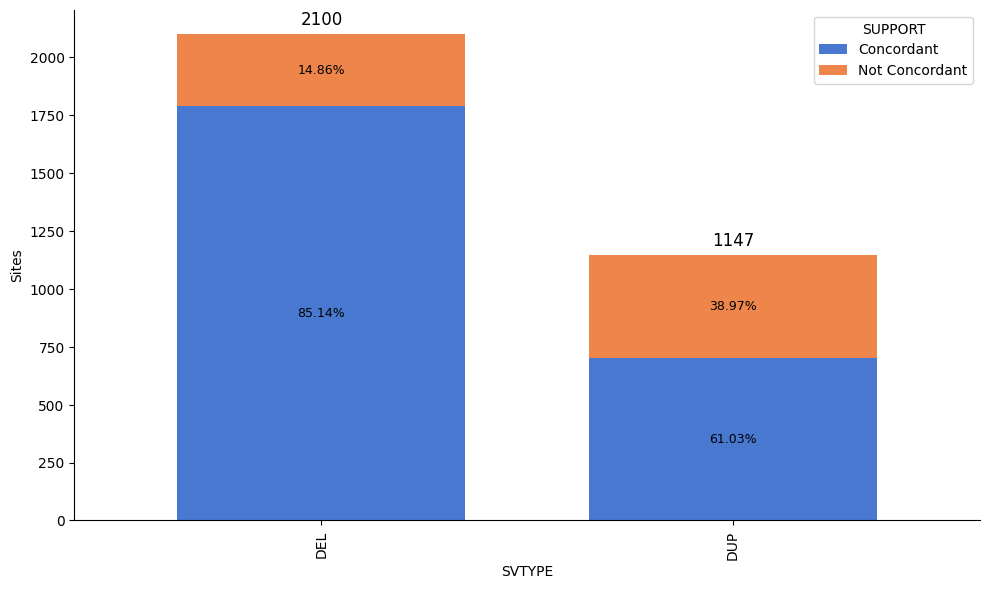

In [51]:
plot_averaged_hist(df, group_col="SVTYPE", support_col="SUPPORT", figsize=(10, 6), width=0.7)

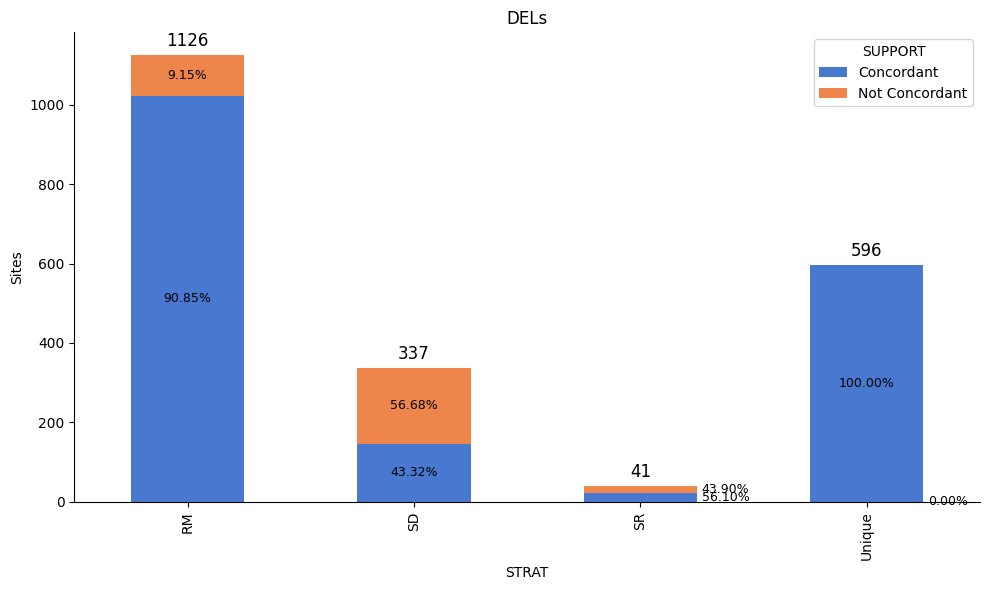

In [52]:
plot_averaged_hist(df[df['SVTYPE'] == 'DEL'], group_col="STRAT", support_col="SUPPORT", figsize=(10, 6), title="DELs")

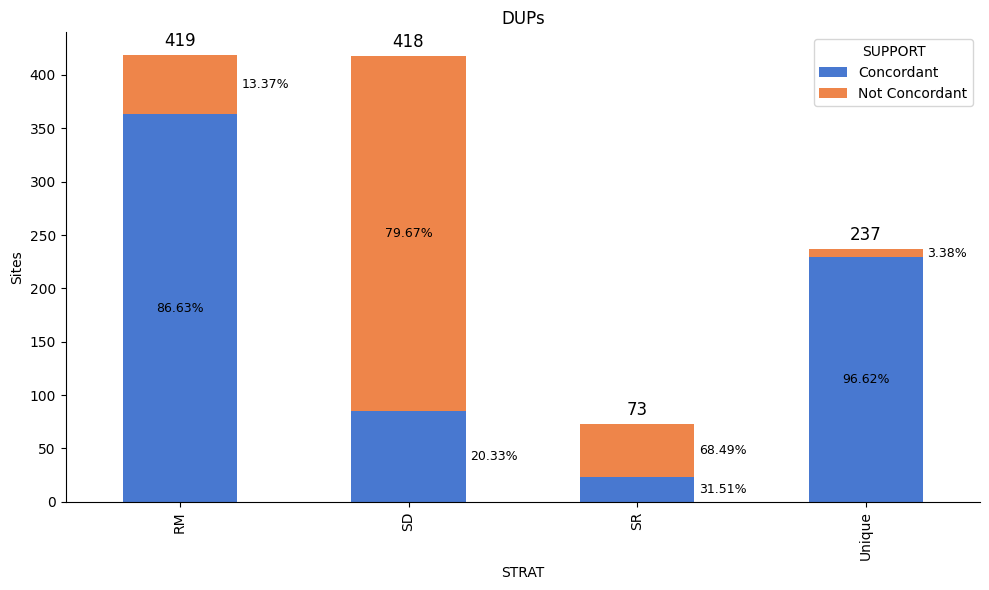

In [53]:
plot_averaged_hist(df[df['SVTYPE'] == 'DUP'], group_col="STRAT", support_col="SUPPORT", figsize=(10, 6), title="DUPs")

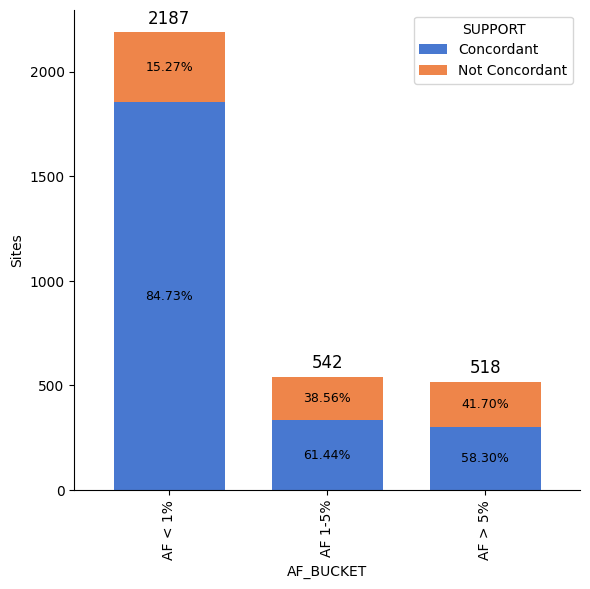

In [54]:
plot_averaged_hist(df, group_col="AF_BUCKET", support_col="SUPPORT", figsize=(6, 6), width=0.7)

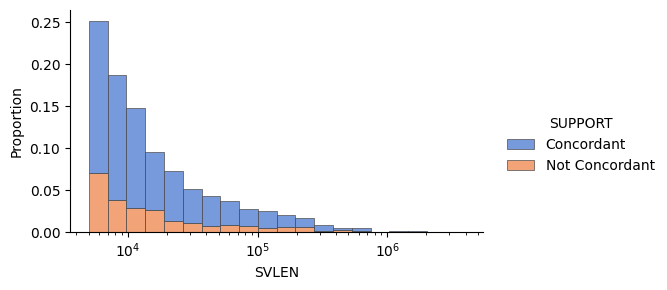

In [55]:
plot_hist(df, "SVLEN", hue="SUPPORT", stat="proportion", log_scale=(True, False))

In [56]:
# plot_hist(df, "SIZE", hue="SUPPORT", stat="proportion", binrange=(-150000, 150000))

### Results for SVLEN > 100KB

In [57]:
display(HTML("<style>.container { width:100% !important; }</style>"))

df_100kb = df[df['SVLEN'] > 100000]

total_sites = df_100kb['VID'].shape[0]
print(f"Total Sites: {total_sites}")

print("\nLR Caller Support >= i")
table_rows = []
for i in range(0, 2):
    table_rows.append(compute_summary(df_100kb, n_samples, support_val=i, filter_val=i))
print(tabulate(table_rows, headers=[">= i"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4))

print("\nLR Caller Support by SVTYPE")
table_rows = []
for svtype in df_100kb["SVTYPE"].dropna().unique():
    table_rows.append(compute_summary(df_100kb, n_samples, pre_filter=True, filter_col="SVTYPE", filter_val=svtype))
print(tabulate(table_rows, headers=["SVTYPE"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4))

print("\nLR Caller Support by SVLEN")
svlen_bins = {
    "SVLEN < 500KB": df_100kb[df_100kb["SVLEN"] < 500000],
    "SVLEN 500KB-1MB": df_100kb[(df_100kb["SVLEN"] >= 500000) & (df_100kb["SVLEN"] <= 1000000)],
    "SVLEN > 1MB": df_100kb[df_100kb["SVLEN"] > 1000000]
}
table_rows = []
for label, subset in svlen_bins.items():
    table_rows.append(compute_summary(subset, n_samples, filter_val=label))
print(tabulate(table_rows, headers=["SVLEN"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4))

print("\nLR Caller Support by STRAT")
table_rows = []
for strat in sorted(df_100kb["STRAT"].dropna().unique(), key=lambda x: (len(x), x)):
    table_rows.append(compute_summary(df_100kb, n_samples, pre_filter=True, filter_col="STRAT", filter_val=strat))
print(tabulate(table_rows, headers=["STRAT"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4))

Total Sites: 277

LR Caller Support >= i
╒════════╤════════════════╤══════════════════════════╤═════════════════════╕
│  >= i  │  Sites/Genome  │  Sites Supported/Genome  │  % Sites Supported  │
╞════════╪════════════════╪══════════════════════════╪═════════════════════╡
│   0    │      1.18      │           1.18           │       100.0%        │
├────────┼────────────────┼──────────────────────────┼─────────────────────┤
│   1    │      1.18      │           0.86           │       72.56%        │
╘════════╧════════════════╧══════════════════════════╧═════════════════════╛

LR Caller Support by SVTYPE
╒══════════╤════════════════╤══════════════════════════╤═════════════════════╕
│  SVTYPE  │  Sites/Genome  │  Sites Supported/Genome  │  % Sites Supported  │
╞══════════╪════════════════╪══════════════════════════╪═════════════════════╡
│   DUP    │      0.7       │           0.47           │       67.07%        │
├──────────┼────────────────┼──────────────────────────┼───────────────────

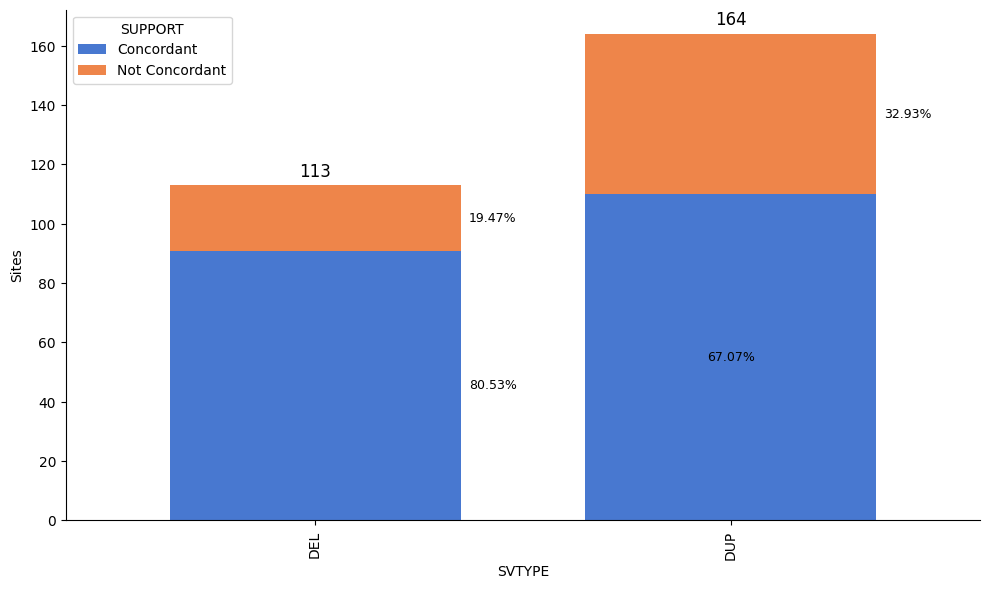

In [58]:
plot_averaged_hist(df_100kb, group_col="SVTYPE", support_col="SUPPORT", figsize=(10, 6), width=0.7)

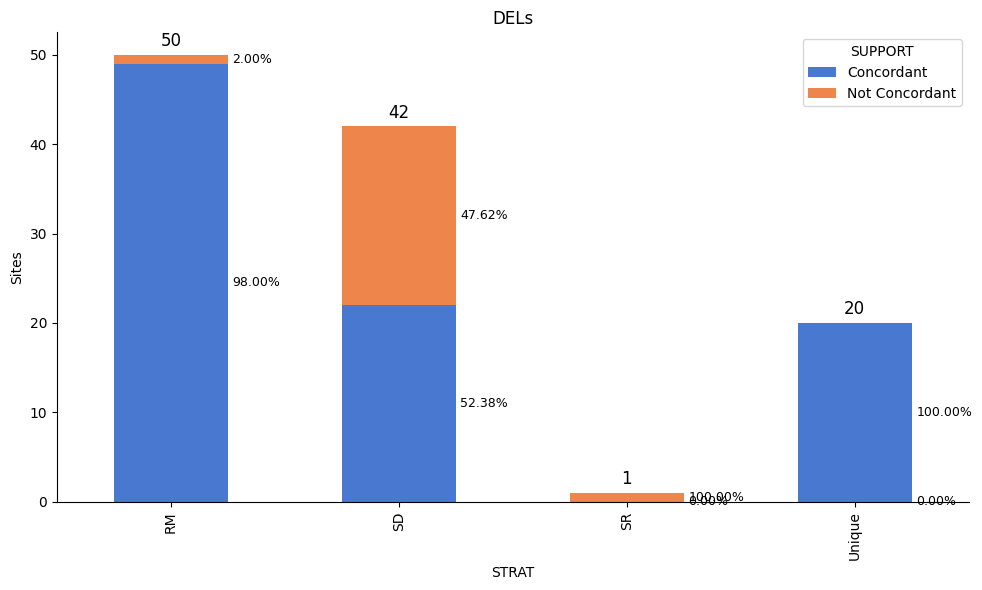

In [59]:
plot_averaged_hist(df_100kb[df_100kb['SVTYPE'] == 'DEL'], group_col="STRAT", support_col="SUPPORT", figsize=(10, 6), title="DELs")

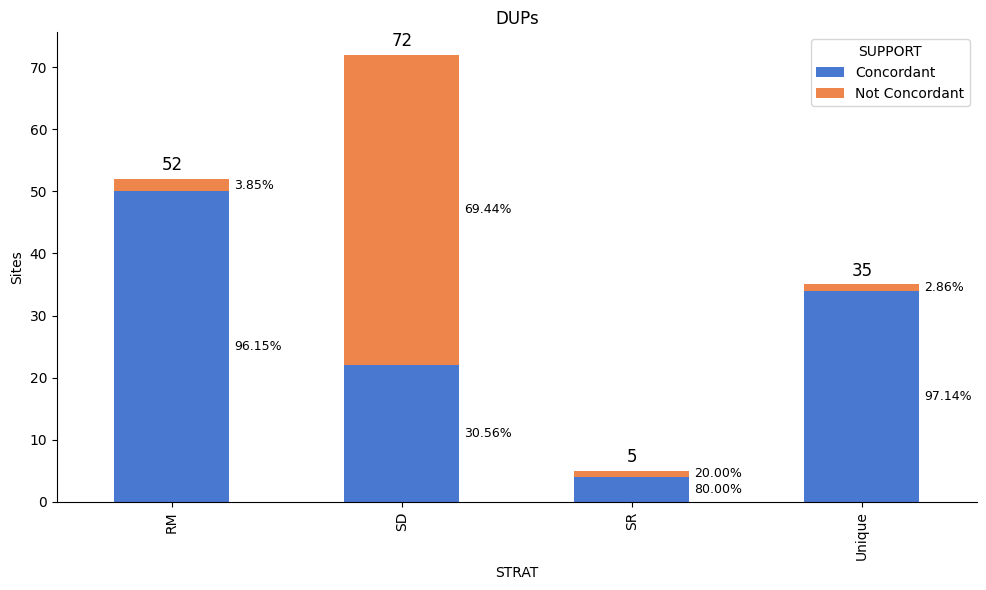

In [60]:
plot_averaged_hist(df_100kb[df_100kb['SVTYPE'] == 'DUP'], group_col="STRAT", support_col="SUPPORT", figsize=(10, 6), title="DUPs")

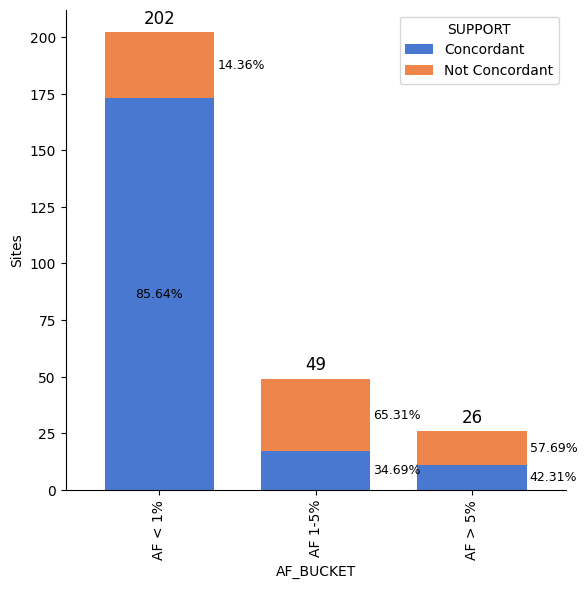

In [61]:
plot_averaged_hist(df_100kb, group_col="AF_BUCKET", support_col="SUPPORT", figsize=(6, 6), width=0.7)

### Manual Review

In [62]:
df_filtered = df[(df['SVLEN'] > 100000) & (df['STATUS'] == 0)].copy()
df_filtered['CHROM_SORT'] = df_filtered['CHROM'].map(chrom_order)
df_filtered = df_filtered.sort_values(['CHROM_SORT', 'POS'])
df_filtered = df_filtered[['VID', 'CHROM', 'POS', 'SVLEN', 'SVTYPE', 'STATUS', 'STRAT', 'AF_BUCKET']]
df_filtered.to_csv(output_missed_cnvs_path, header=None, sep="\t", index=False)
print(len(df_filtered))

# Greedily enforce a minimum distance of 1000 between POS values, and sample subset
# selected = []
# for idx, pos in zip(df_filtered.index, df_filtered['POS']):
#     if not selected or abs(pos - df_filtered.loc[selected[-1], 'POS']) >= 1000:
#         selected.append(idx)
# df_filtered = df_filtered.loc[selected]
# df_filtered = df_filtered.sample(60)

76
